# EDA IBM stock 1min ticks



In [1]:
cd ~/Desktop/MyProjects/moneyManager/

/Users/lduque/Desktop/myProjects/moneyManager


In [2]:
from modeling.createTrainingDataSet import createTrainingDataSet, loadTimeSeries
from modeling.StockModel import generatePipeline
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt

from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import average_precision_score
from sklearn.metrics import plot_precision_recall_curve
from sklearn.model_selection import GridSearchCV

In [3]:
startDay=datetime(2019,2,1)
endDay= datetime(2019,4,1)
dg = loadTimeSeries('IBM', startDay, endDay)

In [4]:
dg.head()

,open_price,high,low,close_price,volume
date,,,,,
2019-02-01 14:31:00,128.793,128.869,128.745,128.783,104129.0
2019-02-01 14:32:00,128.841,129.012,128.774,128.965,7663.0
2019-02-01 14:33:00,128.955,129.003,128.879,128.879,11473.0
2019-02-01 14:34:00,128.907,128.965,128.774,128.879,8411.0
2019-02-01 14:35:00,128.869,128.898,128.803,128.841,4236.0


In [5]:
df = createTrainingDataSet('IBM', 'OIH', startDay=startDay, endDay=endDay, pastStart=4)

In [6]:
df.head()

,stock1open_price,stock1high,stock1low,stock1close_price,stock1volume,stock2open_price,stock2high,stock2low,stock2close_price,stock2volume,target
date,,,,,,,,,,,
2019-02-01 14:31:00,"[nan, nan, nan, nan, 128.793]","[nan, nan, nan, nan, 128.869]","[nan, nan, nan, nan, 128.745]","[nan, nan, nan, nan, 128.783]","[nan, nan, nan, nan, 104129.0]","[nan, nan, nan, nan, 16.579]","[nan, nan, nan, nan, 16.599]","[nan, nan, nan, nan, 16.579]","[nan, nan, nan, nan, 16.599]","[nan, nan, nan, nan, 13509.0]",True
2019-02-01 14:32:00,"[nan, nan, nan, 128.793, 128.841]","[nan, nan, nan, 128.869, 129.012]","[nan, nan, nan, 128.745, 128.774]","[nan, nan, nan, 128.783, 128.965]","[nan, nan, nan, 104129.0, 7663.0]","[nan, nan, nan, 16.579, 16.589000000000002]","[nan, nan, nan, 16.599, 16.599]","[nan, nan, nan, 16.579, 16.57]","[nan, nan, nan, 16.599, 16.589000000000002]","[nan, nan, nan, 13509.0, 47342.0]",False
2019-02-01 14:33:00,"[nan, nan, 128.793, 128.841, 128.955]","[nan, nan, 128.869, 129.012, 129.003]","[nan, nan, 128.745, 128.774, 128.879]","[nan, nan, 128.783, 128.965, 128.879]","[nan, nan, 104129.0, 7663.0, 11473.0]","[nan, nan, 16.579, 16.589000000000002, 16.579]","[nan, nan, 16.599, 16.599, 16.579]","[nan, nan, 16.579, 16.57, 16.53]","[nan, nan, 16.599, 16.589000000000002, 16.54]","[nan, nan, 13509.0, 47342.0, 71947.0]",False
2019-02-01 14:34:00,"[nan, 128.793, 128.841, 128.955, 128.907]","[nan, 128.869, 129.012, 129.003, 128.965]","[nan, 128.745, 128.774, 128.879, 128.774]","[nan, 128.783, 128.965, 128.879, 128.879]","[nan, 104129.0, 7663.0, 11473.0, 8411.0]","[nan, 16.579, 16.589000000000002, 16.579, 16.545]","[nan, 16.599, 16.599, 16.579, 16.609]","[nan, 16.579, 16.57, 16.53, 16.53]","[nan, 16.599, 16.589000000000002, 16.54, 16.609]","[nan, 13509.0, 47342.0, 71947.0, 40480.0]",False
2019-02-01 14:35:00,"[128.793, 128.841, 128.955, 128.907, 128.869]","[128.869, 129.012, 129.003, 128.965, 128.898]","[128.745, 128.774, 128.879, 128.774, 128.803]","[128.783, 128.965, 128.879, 128.879, 128.841]","[104129.0, 7663.0, 11473.0, 8411.0, 4236.0]","[16.579, 16.589000000000002, 16.579, 16.545, 1...","[16.599, 16.599, 16.579, 16.609, 16.648]","[16.579, 16.57, 16.53, 16.53, 16.579]","[16.599, 16.589000000000002, 16.54, 16.609, 16...","[13509.0, 47342.0, 71947.0, 40480.0, 88822.0]",False


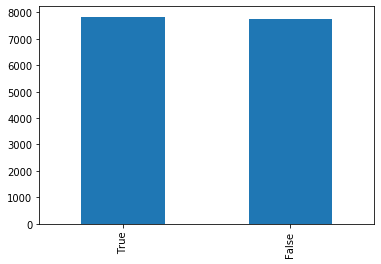

In [7]:
df.target.value_counts().plot.bar()

In [8]:
X = df.copy()
y = X.pop('target')

In [9]:
X.shape

(15600, 10)

In [10]:
X.head()

,stock1open_price,stock1high,stock1low,stock1close_price,stock1volume,stock2open_price,stock2high,stock2low,stock2close_price,stock2volume
date,,,,,,,,,,
2019-02-01 14:31:00,"[nan, nan, nan, nan, 128.793]","[nan, nan, nan, nan, 128.869]","[nan, nan, nan, nan, 128.745]","[nan, nan, nan, nan, 128.783]","[nan, nan, nan, nan, 104129.0]","[nan, nan, nan, nan, 16.579]","[nan, nan, nan, nan, 16.599]","[nan, nan, nan, nan, 16.579]","[nan, nan, nan, nan, 16.599]","[nan, nan, nan, nan, 13509.0]"
2019-02-01 14:32:00,"[nan, nan, nan, 128.793, 128.841]","[nan, nan, nan, 128.869, 129.012]","[nan, nan, nan, 128.745, 128.774]","[nan, nan, nan, 128.783, 128.965]","[nan, nan, nan, 104129.0, 7663.0]","[nan, nan, nan, 16.579, 16.589000000000002]","[nan, nan, nan, 16.599, 16.599]","[nan, nan, nan, 16.579, 16.57]","[nan, nan, nan, 16.599, 16.589000000000002]","[nan, nan, nan, 13509.0, 47342.0]"
2019-02-01 14:33:00,"[nan, nan, 128.793, 128.841, 128.955]","[nan, nan, 128.869, 129.012, 129.003]","[nan, nan, 128.745, 128.774, 128.879]","[nan, nan, 128.783, 128.965, 128.879]","[nan, nan, 104129.0, 7663.0, 11473.0]","[nan, nan, 16.579, 16.589000000000002, 16.579]","[nan, nan, 16.599, 16.599, 16.579]","[nan, nan, 16.579, 16.57, 16.53]","[nan, nan, 16.599, 16.589000000000002, 16.54]","[nan, nan, 13509.0, 47342.0, 71947.0]"
2019-02-01 14:34:00,"[nan, 128.793, 128.841, 128.955, 128.907]","[nan, 128.869, 129.012, 129.003, 128.965]","[nan, 128.745, 128.774, 128.879, 128.774]","[nan, 128.783, 128.965, 128.879, 128.879]","[nan, 104129.0, 7663.0, 11473.0, 8411.0]","[nan, 16.579, 16.589000000000002, 16.579, 16.545]","[nan, 16.599, 16.599, 16.579, 16.609]","[nan, 16.579, 16.57, 16.53, 16.53]","[nan, 16.599, 16.589000000000002, 16.54, 16.609]","[nan, 13509.0, 47342.0, 71947.0, 40480.0]"
2019-02-01 14:35:00,"[128.793, 128.841, 128.955, 128.907, 128.869]","[128.869, 129.012, 129.003, 128.965, 128.898]","[128.745, 128.774, 128.879, 128.774, 128.803]","[128.783, 128.965, 128.879, 128.879, 128.841]","[104129.0, 7663.0, 11473.0, 8411.0, 4236.0]","[16.579, 16.589000000000002, 16.579, 16.545, 1...","[16.599, 16.599, 16.579, 16.609, 16.648]","[16.579, 16.57, 16.53, 16.53, 16.579]","[16.599, 16.589000000000002, 16.54, 16.609, 16...","[13509.0, 47342.0, 71947.0, 40480.0, 88822.0]"


# Debugging the pipeline

In [11]:
pipeline = generatePipeline()
Xt = pipeline.fit_transform(X,y)
# holly SHHHIT !! almost 200 features, and counting !


In [38]:
Xt = Xt.drop(columns='hourminute')

KeyError: "['hourminute'] not found in axis"

In [39]:
Xt.shape

(15600, 162)

In [40]:
Xt.describe()

,stock1open_price_max,stock1open_price_argmax,stock1open_price_min,stock1open_price_argmin,stock1open_price_mean,stock1open_price_std,stock1open_price_median,stock1open_price_last,stock1high_max,stock1high_argmax,stock1high_min,stock1high_argmin,stock1high_mean,stock1high_std,stock1high_median,stock1high_last,stock1low_max,stock1low_argmax,stock1low_min,stock1low_argmin,stock1low_mean,stock1low_std,stock1low_median,stock1low_last,stock1close_price_max,stock1close_price_argmax,stock1close_price_min,stock1close_price_argmin,stock1close_price_mean,stock1close_price_std,stock1close_price_median,stock1close_price_last,stock1volume_max,stock1volume_argmax,stock1volume_min,stock1volume_argmin,stock1volume_mean,stock1volume_std,stock1volume_median,stock1volume_last,stock2open_price_max,stock2open_price_argmax,stock2open_price_min,stock2open_price_argmin,stock2open_price_mean,stock2open_price_std,stock2open_price_median,stock2open_price_last,stock2high_max,stock2high_argmax,stock2high_min,stock2high_argmin,stock2high_mean,stock2high_std,stock2high_median,stock2high_last,stock2low_max,stock2low_argmax,stock2low_min,stock2low_argmin,stock2low_mean,stock2low_std,stock2low_median,stock2low_last,stock2close_price_max,stock2close_price_argmax,stock2close_price_min,stock2close_price_argmin,stock2close_price_mean,stock2close_price_std,stock2close_price_median,stock2close_price_last,stock2volume_max,stock2volume_argmax,stock2volume_min,stock2volume_argmin,stock2volume_mean,stock2volume_std,stock2volume_median,stock2volume_last,stock1open_priceDifference_max,stock1open_priceDifference_argmax,stock1open_priceDifference_min,stock1open_priceDifference_argmin,stock1open_priceDifference_mean,stock1open_priceDifference_std,stock1open_priceDifference_median,stock1open_priceDifference_last,stock1highDifference_max,stock1highDifference_argmax,stock1highDifference_min,stock1highDifference_argmin,stock1highDifference_mean,stock1highDifference_std,stock1highDifference_median,stock1highDifference_last,stock1lowDifference_max,stock1lowDifference_argmax,stock1lowDifference_min,stock1lowDifference_argmin,stock1lowDifference_mean,stock1lowDifference_std,stock1lowDifference_median,stock1lowDifference_last,stock1close_priceDifference_max,stock1close_priceDifference_argmax,stock1close_priceDifference_min,stock1close_priceDifference_argmin,stock1close_priceDifference_mean,stock1close_priceDifference_std,stock1close_priceDifference_median,stock1close_priceDifference_last,stock1volumeDifference_max,stock1volumeDifference_argmax,stock1volumeDifference_min,stock1volumeDifference_argmin,stock1volumeDifference_mean,stock1volumeDifference_std,stock1volumeDifference_median,stock1volumeDifference_last,stock2open_priceDifference_max,stock2open_priceDifference_argmax,stock2open_priceDifference_min,stock2open_priceDifference_argmin,stock2open_priceDifference_mean,stock2open_priceDifference_std,stock2open_priceDifference_median,stock2open_priceDifference_last,stock2highDifference_max,stock2highDifference_argmax,stock2highDifference_min,stock2highDifference_argmin,stock2highDifference_mean,stock2highDifference_std,stock2highDifference_median,stock2highDifference_last,stock2lowDifference_max,stock2lowDifference_argmax,stock2lowDifference_min,stock2lowDifference_argmin,stock2lowDifference_mean,stock2lowDifference_std,stock2lowDifference_median,stock2lowDifference_last,stock2close_priceDifference_max,stock2close_priceDifference_argmax,stock2close_priceDifference_min,stock2close_priceDifference_argmin,stock2close_priceDifference_mean,stock2close_priceDifference_std,stock2close_priceDifference_median,stock2close_priceDifference_last,stock2volumeDifference_max,stock2volumeDifference_argmax,stock2volumeDifference_min,stock2volumeDifference_argmin,stock2volumeDifference_mean,stock2volumeDifference_std,stock2volumeDifference_median,stock2volumeDifference_last,hour,minute
count,15600.000000,15600.000000,15600.000000,15600.000000,15600.000000,15600.000000,15600.000000,15600.000000,15600.000

In [41]:
Xt.head()

,stock1open_price_max,stock1open_price_argmax,stock1open_price_min,stock1open_price_argmin,stock1open_price_mean,stock1open_price_std,stock1open_price_median,stock1open_price_last,stock1high_max,stock1high_argmax,stock1high_min,stock1high_argmin,stock1high_mean,stock1high_std,stock1high_median,stock1high_last,stock1low_max,stock1low_argmax,stock1low_min,stock1low_argmin,stock1low_mean,stock1low_std,stock1low_median,stock1low_last,stock1close_price_max,stock1close_price_argmax,stock1close_price_min,stock1close_price_argmin,stock1close_price_mean,stock1close_price_std,stock1close_price_median,stock1close_price_last,stock1volume_max,stock1volume_argmax,stock1volume_min,stock1volume_argmin,stock1volume_mean,stock1volume_std,stock1volume_median,stock1volume_last,stock2open_price_max,stock2open_price_argmax,stock2open_price_min,stock2open_price_argmin,stock2open_price_mean,stock2open_price_std,stock2open_price_median,stock2open_price_last,stock2high_max,stock2high_argmax,stock2high_min,stock2high_argmin,stock2high_mean,stock2high_std,stock2high_median,stock2high_last,stock2low_max,stock2low_argmax,stock2low_min,stock2low_argmin,stock2low_mean,stock2low_std,stock2low_median,stock2low_last,stock2close_price_max,stock2close_price_argmax,stock2close_price_min,stock2close_price_argmin,stock2close_price_mean,stock2close_price_std,stock2close_price_median,stock2close_price_last,stock2volume_max,stock2volume_argmax,stock2volume_min,stock2volume_argmin,stock2volume_mean,stock2volume_std,stock2volume_median,stock2volume_last,stock1open_priceDifference_max,stock1open_priceDifference_argmax,stock1open_priceDifference_min,stock1open_priceDifference_argmin,stock1open_priceDifference_mean,stock1open_priceDifference_std,stock1open_priceDifference_median,stock1open_priceDifference_last,stock1highDifference_max,stock1highDifference_argmax,stock1highDifference_min,stock1highDifference_argmin,stock1highDifference_mean,stock1highDifference_std,stock1highDifference_median,stock1highDifference_last,stock1lowDifference_max,stock1lowDifference_argmax,stock1lowDifference_min,stock1lowDifference_argmin,stock1lowDifference_mean,stock1lowDifference_std,stock1lowDifference_median,stock1lowDifference_last,stock1close_priceDifference_max,stock1close_priceDifference_argmax,stock1close_priceDifference_min,stock1close_priceDifference_argmin,stock1close_priceDifference_mean,stock1close_priceDifference_std,stock1close_priceDifference_median,stock1close_priceDifference_last,stock1volumeDifference_max,stock1volumeDifference_argmax,stock1volumeDifference_min,stock1volumeDifference_argmin,stock1volumeDifference_mean,stock1volumeDifference_std,stock1volumeDifference_median,stock1volumeDifference_last,stock2open_priceDifference_max,stock2open_priceDifference_argmax,stock2open_priceDifference_min,stock2open_priceDifference_argmin,stock2open_priceDifference_mean,stock2open_priceDifference_std,stock2open_priceDifference_median,stock2open_priceDifference_last,stock2highDifference_max,stock2highDifference_argmax,stock2highDifference_min,stock2highDifference_argmin,stock2highDifference_mean,stock2highDifference_std,stock2highDifference_median,stock2highDifference_last,stock2lowDifference_max,stock2lowDifference_argmax,stock2lowDifference_min,stock2lowDifference_argmin,stock2lowDifference_mean,stock2lowDifference_std,stock2lowDifference_median,stock2lowDifference_last,stock2close_priceDifference_max,stock2close_priceDifference_argmax,stock2close_priceDifference_min,stock2close_priceDifference_argmin,stock2close_priceDifference_mean,stock2close_priceDifference_std,stock2close_priceDifference_median,stock2close_priceDifference_last,stock2volumeDifference_max,stock2volumeDifference_argmax,stock2volumeDifference_min,stock2volumeDifference_argmin,stock2volumeDifference_mean,stock2volumeDifference_std,stock2volumeDifference_median,stock2volumeDifference_last,hour,minute
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [42]:
Xtrain, ytrain = Xt[:-5600], y[:-5600] 
Xtest, ytest = Xt[-5600:], y[-5600:]

# L2 regularization

In [43]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
C = 10**np.linspace(-10,1,100) 
grid_parameters = {
    'C': C,
    'class_weight': ['balanced'],
    'penalty':['l2']
}

clf = GridSearchCV(LogisticRegression(solver='liblinear', multi_class='ovr', max_iter=10000, C=C), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(Xtrain, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

0.5371763497638306
---
stock2lowDifference_min            3.170836
stock2open_priceDifference_mean    2.897023
stock2lowDifference_max            2.803161
stock2open_priceDifference_last    2.282281
stock2lowDifference_std            2.244335
                                     ...   
stock1close_price_argmax           0.012939
stock1highDifference_argmin        0.009012
stock2low_max                      0.007980
stock2open_price_argmin            0.007784
stock2close_price_min              0.001214
Length: 162, dtype: float64
---
LogisticRegression(C=10.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=10000, multi_class='ovr', n_jobs=None, penalty='l2',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)


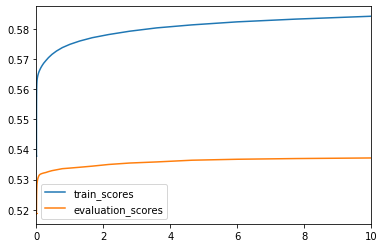

In [44]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=Xt.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

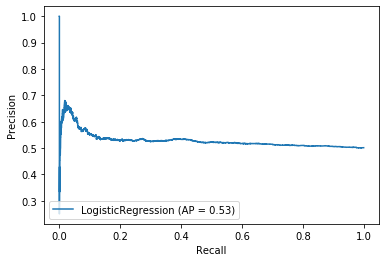

In [45]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt

disp = plot_precision_recall_curve(clf.best_estimator_, Xtest, ytest)
#disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

# L1 regularization

In [46]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
C = 10**np.linspace(-10,0,100) 
grid_parameters = {
    'C': C,
    'class_weight': ['balanced'],
    'penalty':['l1']
}

clf = GridSearchCV(LogisticRegression(solver='saga',max_iter=1000, multi_class='ovr', C=C), grid_parameters, scoring='average_precision', cv=2, return_train_score=True)
clf.fit(Xtrain, ytrain);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)
/Users/lduque/Desktop/myProjects/moneyManager/venv-money/lib/python3.6/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


0.5391984936420617
---
minute                             0.574916
stock1highDifference_argmax        0.051686
stock2open_price_argmax            0.034885
stock2low_argmax                   0.019074
hour                               0.016355
                                     ...   
stock1close_priceDifference_min    0.000000
stock1close_priceDifference_max    0.000000
stock1lowDifference_last           0.000000
stock1lowDifference_median         0.000000
stock1open_price_max               0.000000
Length: 162, dtype: float64
---
LogisticRegression(C=0.038535285937105354, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='ovr', n_jobs=None, penalty='l1',
                   random_state=None, solver='saga', tol=0.0001, verbose=0,
                   warm_start=False)


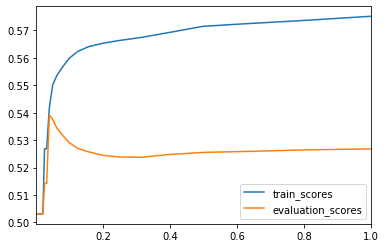

In [47]:
ds.plot()
print(ds.evaluation_scores.max())
print('---')
print(pd.Series(clf.best_estimator_.coef_[0], index=Xt.columns).abs().sort_values(ascending=False))
print('---')
print(clf.best_estimator_)

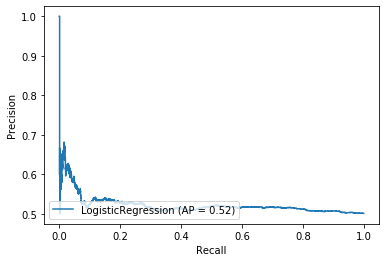

In [48]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
import matplotlib.pyplot as plt
disp = plot_precision_recall_curve(clf.best_estimator_, Xtest, ytest)
#disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))

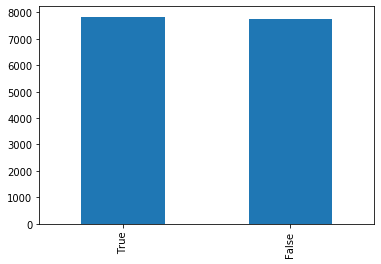

In [49]:
y.value_counts().plot.bar()

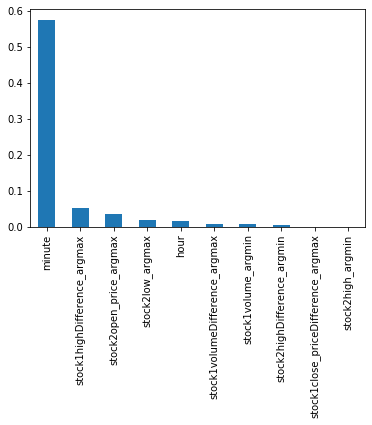

In [51]:
pd.Series(clf.best_estimator_.coef_[0], index=Xt.columns).abs().sort_values(ascending=False)[:10].plot.bar()

# Random Forest

In [ ]:
parameters = 

regr = RandomForestRegressor(criterion='mse')
grid = GridSearchCV(regr, parameters, cv=3, scoring='neg_mean_squared_error', return_train_score=True)
grid.fit(X_train, y_train)
model = grid.best_estimator_

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier


grid_parameters = {
    'min_samples_leaf' : [100, 1000, 2000],
    'max_depth': [10, 50,100],
    'n_estimators': [100, 200, 300],   
    'max_features': ['sqrt']
}

clf = GridSearchCV(RandomForestClassifier(), grid_parameters, scoring='average_precision', cv=3, return_train_score=True)
clf.fit(Xt, y);  
test_scores = clf.cv_results_['mean_test_score']
train_scores = clf.cv_results_['mean_train_score']
ds = pd.DataFrame({'train_scores':train_scores, 'evaluation_scores':test_scores}, index=C)

In [ ]:

print "feature importance"
feature_importance = pd.DataFrame({'feature': Xt.columns, 'importance':grid.best_estimator_.feature_importances_}).set_index('feature').sort_values(by=['importance'], ascending=False)
#feature_importance[feature_importance.importance>0].plot.bar(figsize=(15,5))

## MIGHT BE USEFUL?. A precision recall-curve with only one training split.

In [ ]:
# temporal split of train/test
trainPercentage = 50
testBegins = (len(X)*trainPercentage)//100
Xtrain, ytrain = X[:testBegins], y[:testBegins]
Xtest, ytest = X[testBegins:], y[testBegins:]

In [ ]:
model = generatePipeline();
model.fit(Xtrain, ytrain);

In [ ]:
# how to pick the threshold
ypredictedTrain=list(model.predict_proba(Xtrain)[:,1])
ypredictedTrain.sort(reverse=True)
threshold = ypredictedTrain[100]

In [ ]:
# ploting precision-recall !
base_rate = sum(ytest)/len(ytest)
ypredicted=model.predict_proba(Xtest)[:,1]
average_precision = average_precision_score(ytest, ypredicted)
disp = plot_precision_recall_curve(model, Xtest, ytest)
disp.ax_.set_title('2-class Precision-Recall curve: AP={0:0.2f}'.format(average_precision))
plt.plot([0, 1], [base_rate, base_rate]);

In [ ]:
evaluationDF = pd.DataFrame({'predicted':ypredicted, 'target':ytest}, index=Xtest.index)
topPredictions = evaluationDF.sort_values(by='predicted', ascending=False)[:100]

In [ ]:
topPredictions

In [ ]:
evaluationDF['thresholdedPrediction']=evaluationDF.predicted>threshold

In [ ]:
topPredictions=evaluationDF[evaluationDF.thresholdedPrediction==True]

In [ ]:
topPredictions